# Apple Fruit Notebook

The idea of this notebook is to test strategies to hedge apple fruit future price in the Zhengzhou Commodity Exchange. Testable ideas like cross-hedging and exchange rate hedging

After adjustments, other features/variables such as climate are going to be introduced so other hypotheses of hedge may be tested.

**The reasoning is around a western producer of apple that would like to hedge his harvest. The Chinese marke isn't that accessible, that is why he would like to hedge in the american market.**

# Ordered Analysis

1) Initially, imported several commodities futures datasets using Yfinance library: Orange juice, sugar, soy beans, cotton, wheat, corn, coffee, cocoa, lean hogs and a commodities ETF.

2) Created a continuous time-series for the apple fruit future price. The strategy was the following:
Rank the 2 nearest future contracts to expire. When the closest to expire contract expired, change to the second. This break was smoothed by allocating weights for the futures price of the 2 interpolated contracts 5 days before the change.

3) Using the adjusted time series, measured the volatility, tested for normality, calculated the correlation between apple fruit price and other commodities and estimated the max drawdown since 2020.

**Summarized results:**
* The VaR with 95% of confidence is around 3%, as expected, since it is more volatile then S&P500, but less volatile then Bitcoin.
* With the Shapiro-Wilk test the series doesn't show normally distributed returns.
* **the correlation between apple fruit price and other commodities is really low, that was kinda surprising, but show the difference around the production of agricultural products**
*Max Drawdown for a period of 5 years was 57%. The apple fruit price did a big peak in 2022.

4) Since any commodity traded in the USA showed relevant correlation with the apple fruit price, the optionality of cross-hedge wasn't viable.

  In this way, it is possible to hedge against oscillations in the exchange rate between chinese Yuan and american Dollar. A basic hedge, defining a hedge ratio static (1.1) for the whole analysis **dropped the daily variance of the apple future price closely to 4%, so, a 2% drop on daily volatility.**

  _important to note that the static hedge ratio suffers from look ahead bias, because the hedge ratio was calculated from 2020-2025 and then used against the same period. A trader in 2022 wouldn't know the beta of 2023..._

  After that, a new hedge was tested using a dynamic hedge ratio. This composition didn't suffer from look-ahead bias because calculated the optimal hedge ratio using the last 60 days. Without a limit for hedging, the composition achieved the same result as the static hedge, but taking more risk, since it levered a lot the portfolio on some points to keep the position hedged.
  **To solve the leverage issue, the dynamic hedge ratio was calculated with a limit of +-2. With this, the variance could be reduced in 550 BPS.**

5) Next step was to run a regression of the apple fruit price against climate variables from the regions where the biggest producers of apple are available, like China, Russia, Brazil, etc. The climate data came from a NASA API and the choosen variables were: Average temperature, max temperature, min temperature and estimated milimeters of rain.
 We performed 3 regressions:
 * using all variables, we got a r^2 of 0.09, but an adjusted r^2 of 0.03, since we had lots of variables and they suffered from big collinearity. Apparently, Chinese regions features were responsable for the explanatory power, together with the american feature from Washington and Italian feature from the region of Bolzano.
 * the second regression used only Chinese climate features and almost solved the VIF problem, but got only 0.04 r^2 and 0.036 adjusted r^2.
 * the third regression incorporated Washington (USA) and Bolzano (Italy) features. The results improved a little, with a 0.058 r^2 and a 0.046 adjusted r^2, but the VIF issue came back.
 -> Explaining close to 5% of the variance is not much, but for a quick analysis just with simple climate features was kind a good result.

 **So, a complicated hedge could be structured against the climate in some regions, but would reduce the variance just marginally for a producer of apples. Since the exchange rate hedge is much easier to be made and reduces the variance by the same amount, probably it is a better option.**

## Commodities DataSets

Initially, I import datasets from commodities futures such as orange juice, sugar, etc and the Commodities Price Tracker ETF 'Invesco DB Commodity Index Tracking Fund'.

The composition of the ETF is:

Gold 100 Troy Ounces; Brent Crude Oil; Light Sweet Crude Oil; Henry Hub Natural Gas; Corn; Gas Oil; Soybean; Primary Aluminum; Live Cattle; NY Harbor ULSD; Lean Hogs; Reformulated Gasoline Blendstock for Oxygen Blending RBOB; Copper; Silver; Wheat; Feeder Cattle; Number 11 World Sugar; Soybean Oil; Soybean Meal; Nickel; Number 2 Cotton; Hard Red Winter Wheat; C Coffee; Cocoa; Zinc; Platinum; Lead


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Other Commodities

In [6]:
# Sugar Futures
sugar_futures = yf.download('SB=F', '2020-03-23')
sugar_futures = sugar_futures.reset_index()
sugar_futures = sugar_futures[['Date', 'Close', 'Volume']]
# sugar_futures.head()

[*********************100%***********************]  1 of 1 completed


In [7]:
# Orange Juice Futures
orange_juice_futures = yf.download('OJ=F', '2020-03-23')
orange_juice_futures = orange_juice_futures.reset_index()
orange_juice_futures = orange_juice_futures[['Date', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [8]:
# Invesco DB Commodity Index Tracking Fund
commoditie_etf = yf.download('DBC', '2020-03-23')
commoditie_etf = commoditie_etf.reset_index()
commoditie_etf = commoditie_etf[['Date', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [9]:
# SOYBEAN FUTURES
soybean_futures = yf.download('ZS=F', '2020-03-23')
soybean_futures = soybean_futures.reset_index()
soybean_futures = soybean_futures[['Date', 'Close', 'Volume']]

# COTTON FUTURES
cotton_futures = yf.download('CT=F', '2020-03-23')
cotton_futures = cotton_futures.reset_index()
cotton_futures = cotton_futures[['Date', 'Close', 'Volume']]

# WHEAT FUTURES
wheat_futures = yf.download('ZW=F', '2020-03-23')
wheat_futures = wheat_futures.reset_index()
wheat_futures = wheat_futures[['Date', 'Close', 'Volume']]

# CORN FUTURES
corn_futures = yf.download('ZC=F', '2020-03-23')
corn_futures = corn_futures.reset_index()
corn_futures = corn_futures[['Date', 'Close', 'Volume']]

# COFFEE FUTURES
coffee_futures = yf.download('KC=F', '2020-03-23')
coffee_futures = coffee_futures.reset_index()
coffee_futures = coffee_futures[['Date', 'Close', 'Volume']]

# COCOA FUTURES
cocoa_futures = yf.download('CC=F', '2020-03-23')
cocoa_futures = cocoa_futures.reset_index()
cocoa_futures = cocoa_futures[['Date', 'Close', 'Volume']]

# LEAN HOGS FUTURES
lean_hogs_futures = yf.download('LH=F', '2020-03-23')
lean_hogs_futures = lean_hogs_futures.reset_index()
lean_hogs_futures = lean_hogs_futures[['Date', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Apple Fruit

In [10]:
# Adjusting columns of the apple fruit future price dataset
rename_map = {'Trading Day': 'Date',

'Prev.Settle': 'PrevSettle',

'Pre Settle': 'PrevSettle',

'Settlement': 'Settle',

'Volume (lot)': 'Volume',

'O.I.': 'OpenInterest',

'OI Change': 'OIChange',

'Turnover (RMB 10,000)': 'Turnover',

'DeliverySettlementPrice': 'FinalSettle',

'Final Settle': 'FinalSettle'}

In [11]:
# Adjusting columns of the apple fruit future price dataset
rename_map = {'Trading Day': 'Date',

'Prev.Settle': 'PrevSettle',

'Pre Settle': 'PrevSettle',

'Settlement': 'Settle',

'Volume (lot)': 'Volume',

'O.I.': 'OpenInterest',

'OI Change': 'OIChange',

'Turnover (RMB 10,000)': 'Turnover',

'DeliverySettlementPrice': 'FinalSettle',

'Final Settle': 'FinalSettle'}

# I saved the database of apple fruit future price in CSV files. I stored then
# on my personal computer and on Google Drive. Sometimes I code in Google Coolab
# and sometimes in Vscode. The code below adjust the importing condition to the
# platform I am using

import os
from pathlib import Path

def get_apfutures_path(year):

    # 1. Try Google Colab path first
    colab_path = Path(f'/content/drive/MyDrive/MeusLogs/APFUTURES{year}.txt')
    if colab_path.exists():
        return str(colab_path)

    # 2. Try a local PC path.
    # IMPORTANT: If running on your local PC and your files are not in Google Drive's default synced location,
    # update 'YOUR_LOCAL_PC_BASE_PATH' to the base directory where your APFUTURES files are located.
    # For example: 'C:/Users/YourUser/Documents/MyData/' or '/home/youruser/data/'.
    YOUR_LOCAL_PC_BASE_PATH = 'G:/Meu Drive/MeusLogs'

    if YOUR_LOCAL_PC_BASE_PATH:
        pc_path = Path(YOUR_LOCAL_PC_BASE_PATH) / f'APFUTURES{year}.txt'
        if pc_path.exists():
            return str(pc_path)

    # 3. As a fallback, try the current working directory
    cwd_path = Path.cwd() / f'APFUTURES{year}.txt'
    if cwd_path.exists(): # Added .exists() check for cwd_path as well
        return str(cwd_path)

    return str(cwd_path)

years = range(2020, 2026)
apple_dfs = []

for year in years:
    file_path = get_apfutures_path(year)
    print(f'Reading: {file_path}')
    df = pd.read_csv(file_path, sep='|' , skiprows=1)
    df.columns = df.columns.str.strip()
    df = df.rename(columns=rename_map)
    apple_dfs.append(df)

apple_dfs = pd.concat(apple_dfs, ignore_index=True)

Reading: G:\Meu Drive\MeusLogs\APFUTURES2020.txt
Reading: G:\Meu Drive\MeusLogs\APFUTURES2021.txt
Reading: G:\Meu Drive\MeusLogs\APFUTURES2022.txt
Reading: G:\Meu Drive\MeusLogs\APFUTURES2023.txt
Reading: G:\Meu Drive\MeusLogs\APFUTURES2024.txt
Reading: G:\Meu Drive\MeusLogs\APFUTURES2025.txt


In [12]:
# Way to create a continuous price serie from futures

all_trading_days = sorted(apple_dfs['Date'].unique())
all_trading_days = pd.to_datetime(all_trading_days)

def calculate_expire(contract_code):

    # Regex 'AP(\d+)' to take only numbers
    digits = contract_code.replace('AP', '').strip()


    # the first character is year (0=2020, 1=2021...), the rest is month
    year = 2020 + int(digits[0])
    month = int(digits[1:])

    day_month = [d for d in all_trading_days if d.year == year and d.month == month]

    # 4. get 10º business day of each month -> contract specification
    if len(day_month) >= 10:
        return day_month[9]
    else:
        return pd.NaT

apple_dfs['Real Expire'] = apple_dfs['Contract Code'].apply(calculate_expire)

In [13]:
# Drop rows where 'Real Expire' is NaT
apple_dfs = apple_dfs.dropna(subset=['Real Expire']).copy()

print(f"Rows after dropping NaT: {len(apple_dfs)}")

Rows after dropping NaT: 8659


In [14]:
apple_dfs['Rank'] = apple_dfs.groupby('Date')['Real Expire'].rank(method='first')

apple_dfs['Date'] = pd.to_datetime(apple_dfs['Date'])

apple_dfs['Days to Expire'] = (apple_dfs['Real Expire'] - apple_dfs['Date']).dt.days

apple_dfs.loc[apple_dfs['Days to Expire'] <= 5, 'Weights'] = apple_dfs['Days to Expire'] / 5
apple_dfs['Weights'] = apple_dfs['Weights'].fillna(1.0)

df_rank1 = apple_dfs[apple_dfs['Rank'] == 1].set_index('Date')
df_rank2 = apple_dfs[apple_dfs['Rank'] == 2].set_index('Date')
df_rank1['Settle'] = pd.to_numeric(df_rank1['Settle'].astype(str).str.replace(',', '').str.strip())
df_rank2['Settle'] = pd.to_numeric(df_rank2['Settle'].astype(str).str.replace(',', '').str.strip())

continuous_settle = (df_rank1['Settle'] * df_rank1['Weights'])+(df_rank2['Settle'] * (1-df_rank1['Weights']))

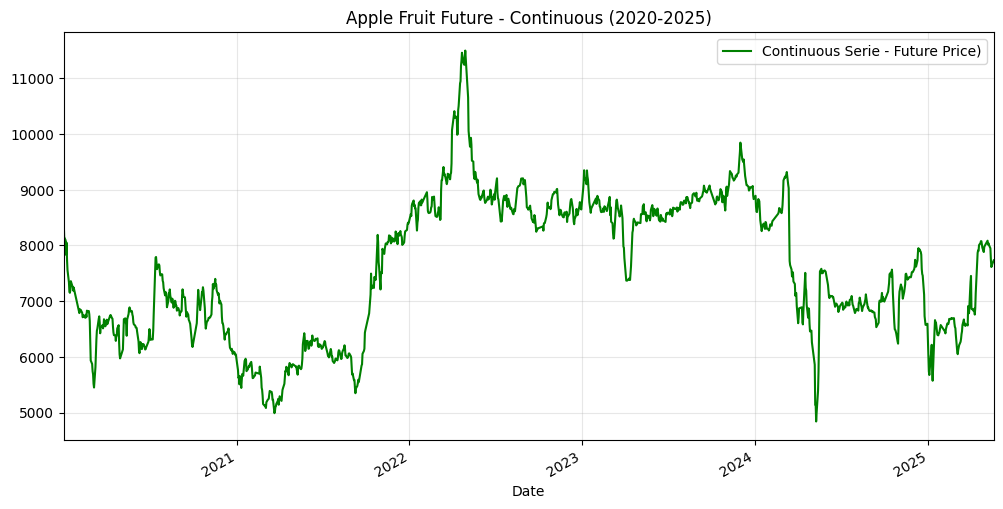

In [15]:
plt.figure(figsize=(12, 6))
continuous_settle.plot(label='Continuous Serie - Future Price)', color='green')
plt.title('Apple Fruit Future - Continuous (2020-2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.margins(x=0)
plt.show()

#### Adjust series for dollar
Because the apple fruit future is quoted in Chinese Yuan

In [16]:
# CNY=X -> ticker for yuan for dollars
df_yuan_dollar = yf.download('CNY=X', start='2020-01-01', end='2025-12-31')

#print(df_yuan_dollar['Close'].head())

Failed to get ticker 'CNY=X' reason: Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed


In [17]:
continuous_settle = continuous_settle.dropna()

In [18]:
# add to the yuan for dollars df the dates at the apple fruit future df. ffill method uses the last values to empty dates
df_yuan_dollar_adjusted = df_yuan_dollar.reindex(index = continuous_settle.index, method='ffill')
continuous_settle = continuous_settle.to_frame(name='Settle')
continuous_settle['Price_USD'] = continuous_settle['Settle'] / df_yuan_dollar_adjusted[('Close', 'CNY=X')]

## Apple Fruit Price Measures

#### Log returns of Apple Futures

The analysis of returns from the apple futures show that the future contract has been much more volatil between 2024 and 2025 then before (from 2020).

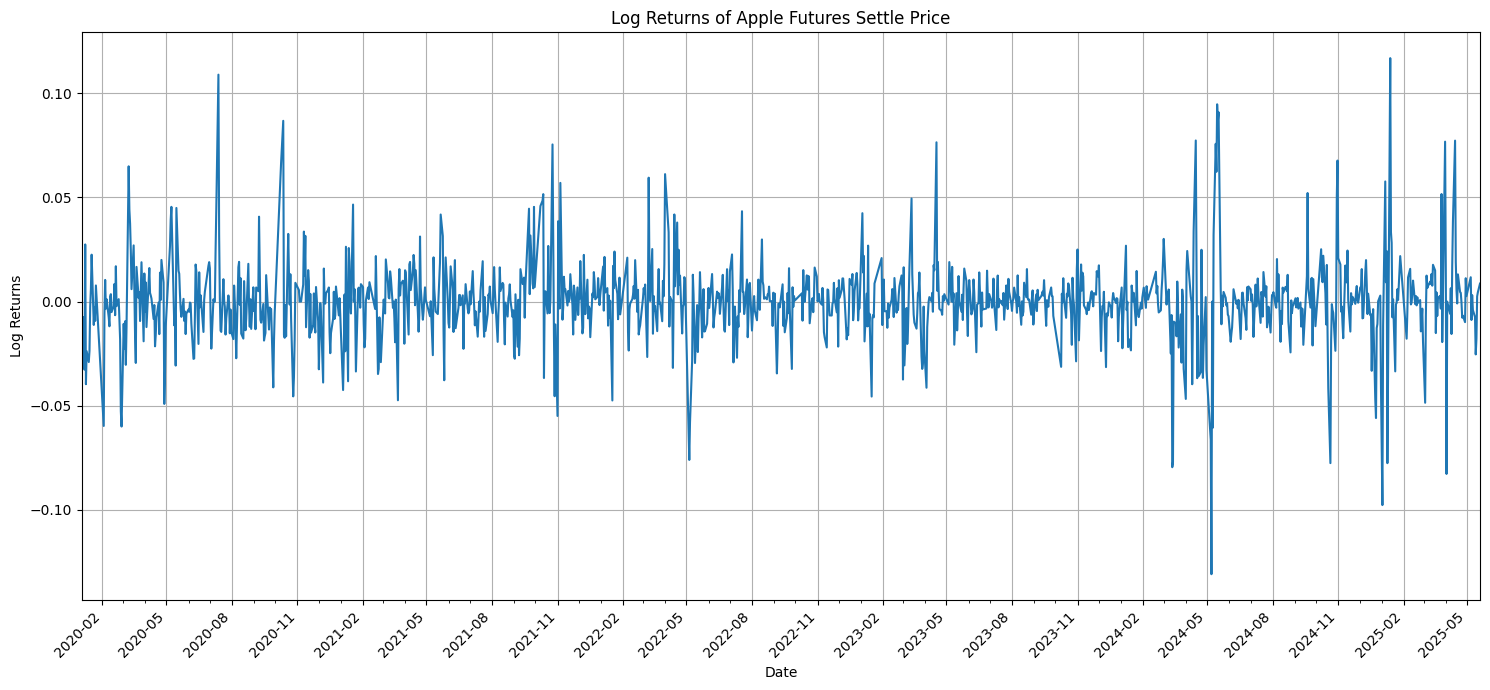

In [19]:
import matplotlib.dates as mdates

apple_continuous_final = continuous_settle.copy()
apple_continuous_final['Date'] = apple_continuous_final.index # Set 'Date' column from the index
apple_continuous_final = apple_continuous_final.dropna(subset=['Settle'])
apple_continuous_final['Returns'] = apple_continuous_final['Settle'].pct_change()
apple_continuous_final['LogReturns'] = np.log(apple_continuous_final['Settle'] / apple_continuous_final['Settle'].shift(1))


fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(apple_continuous_final['Date'], apple_continuous_final['LogReturns'])
ax.set_title('Log Returns of Apple Futures Settle Price')
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
ax.grid(True)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.margins(x=0)
plt.show()

In [20]:

logr = apple_continuous_final['LogReturns'].dropna()
r_simple = apple_continuous_final['Returns'].dropna()

# Daily volatility (sample std, ddof=1) and annualize by sqrt(252)
daily_vol = logr.std(ddof=1)
annualized_vol = daily_vol * np.sqrt(252)

# Annualized returns from log-returns (continuous compounding -> simple)
mu_log = logr.mean()
ann_continuous = mu_log * 252
ann_simple_from_log = np.exp(ann_continuous) - 1

# Alternatives using simple returns
ann_arith_from_simple = (1 + r_simple.mean())**252 - 1 if len(r_simple) > 0 else np.nan
if len(r_simple) > 0:
    geom_daily = (1 + r_simple).prod()**(1.0/len(r_simple)) - 1
    ann_geom = (1 + geom_daily)**252 - 1
else:
    geom_daily = np.nan
    ann_geom = np.nan

print(f'Daily vol (sample, ddof=1): {daily_vol:.6f}')
print(f'Annualized vol (sqrt(252)): {annualized_vol:.4%}')
print(f'Mean daily log-return: {mu_log:.6f}')
print(f'Annual continuous return (mu*252): {ann_continuous:.4%}')
print(f'Annual simple return from log-returns: {ann_simple_from_log:.4%}')
print(f'Annual arithmetic (simple) from mean simple returns: {ann_arith_from_simple:.4%}')
print(f'Annual geometric return (from simple returns): {ann_geom:.4%}')

Daily vol (sample, ddof=1): 0.019315
Annualized vol (sqrt(252)): 30.6620%
Mean daily log-return: -0.000066
Annual continuous return (mu*252): -1.6604%
Annual simple return from log-returns: -1.6467%
Annual arithmetic (simple) from mean simple returns: 3.0929%
Annual geometric return (from simple returns): -1.6467%


In [21]:

n = len(logr)
print("N (log-returns):", n)

print("\nLog Returns Summary:")
print(logr.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

daily_vol_sample = logr.std(ddof=1)
ann_vol = daily_vol_sample * np.sqrt(252)

print(f"\nDaily vol (sample ddof=1): {daily_vol_sample:.6f} ({daily_vol_sample:.2%})")
print(f"Annualized vol (sqrt(252)): {ann_vol:.6f} ({ann_vol:.2%})")

# Outliers
abs_sorted = logr.abs().sort_values(ascending=False)

# Check if there is any year with wrong number of obs
if 'Date' in apple_continuous_final.columns:
    apple_continuous_final['Date'] = pd.to_datetime(apple_continuous_final['Date'])
    yrs = apple_continuous_final['Date'].dt.year.value_counts().sort_index()
    print('\nObservations per year:')
    print(yrs)

rolling = logr.rolling(window=21).std(ddof=1) * np.sqrt(252)
print('\nRolling 21-day annualized vol stats:')
print(rolling.dropna().describe())

print('\nMin settle:', apple_continuous_final['Settle'].min())
print('Max settle:', apple_continuous_final['Settle'].max())
print('Any zeros or negatives in settle', (apple_continuous_final['Settle'] <= 0).any())
print('NaNs in Settle or Returns?', apple_continuous_final[['Settle','Returns','LogReturns']].isna().sum())

N (log-returns): 1299

Log Returns Summary:
count    1299.000000
mean       -0.000066
std         0.019315
min        -0.130902
1%         -0.055954
5%         -0.029458
10%        -0.018625
25%        -0.007529
50%         0.000217
75%         0.006967
90%         0.016709
95%         0.026369
99%         0.066861
max         0.116925
Name: LogReturns, dtype: float64

Daily vol (sample ddof=1): 0.019315 (1.93%)
Annualized vol (sqrt(252)): 0.306620 (30.66%)

Observations per year:
Date
2020    243
2021    243
2022    242
2023    242
2024    242
2025     88
Name: count, dtype: int64

Rolling 21-day annualized vol stats:
count    1279.000000
mean        0.267967
std         0.145785
min         0.083158
25%         0.162022
50%         0.225171
75%         0.328822
max         0.928115
Name: LogReturns, dtype: float64

Min settle: 4839.0
Max settle: 11500.0
Any zeros or negatives in settle False
NaNs in Settle or Returns? Settle        0
Returns       1
LogReturns    1
dtype: int64


#### Apple Fruit price kurtosis, skewness and normality test

The analysis of log returns makes explicit a context where the distribution of returns is a little left-skewed, the kurtosis is very high, so fat tails occur, and using the Shapiro Wilk test it is possible to conclude that the returns don't follow a normal distribution

In [22]:
from scipy.stats import kurtosis, skew, shapiro

apple_skew = skew(logr)

# Calculate excess kurtosis (Fisher definition, kurtosis - 3).
# Use bias=False to request the sample (unbiased) estimator where available.
apple_kurt_excess = kurtosis(logr, fisher=True, bias=False)

# Also provide Pearson (regular) kurtosis which includes the 3
apple_kurt_pearson = kurtosis(logr, fisher=False, bias=False)

shapiro_wilk_stat, shapiro_wilk_p = shapiro(logr)

print(f"\nSkewness of log-returns: {apple_skew:.4f}")
print(f"Excess kurtosis (Fisher, sample-corrected): {apple_kurt_excess:.4f}")
print(f"Pearson kurtosis (including 3): {apple_kurt_pearson:.4f}")
print(f"Shapiro-Wilk test statistic: {shapiro_wilk_stat:.4f}, p-value: {shapiro_wilk_p:.4f}")


Skewness of log-returns: 0.2694
Excess kurtosis (Fisher, sample-corrected): 7.5570
Pearson kurtosis (including 3): 10.5570
Shapiro-Wilk test statistic: 0.8803, p-value: 0.0000


#### Correlation between Apple Fruit returns and other commodities

This simplitic analysis shows that commodities traded on the USA don't make a good fit for a cross-hedge with apple fruit. Deeper analysis could reach different results.

Returns DataFrame shape: (1204, 11)
Columns: ['Apple', 'Orange Juice', 'Sugar', 'ETF DB', 'Soybean', 'Cotton', 'Wheat', 'Corn', 'Coffee', 'Cocoa', 'Apple USD']


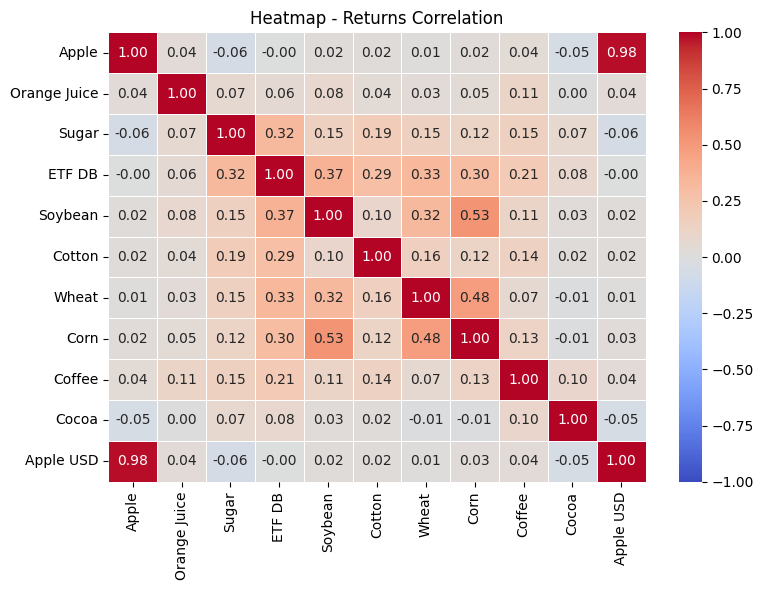

In [23]:
import seaborn as sns

apple_usd_returns = apple_continuous_final.set_index('Date')['Price_USD'].pct_change().dropna().rename('Apple USD')

def flatten_yfinance_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df


orange_juice_futures = flatten_yfinance_columns(orange_juice_futures)
sugar_futures = flatten_yfinance_columns(sugar_futures)
commoditie_etf = flatten_yfinance_columns(commoditie_etf)
soybean_futures = flatten_yfinance_columns(soybean_futures)
cotton_futures = flatten_yfinance_columns(cotton_futures)
wheat_futures = flatten_yfinance_columns(wheat_futures)
corn_futures = flatten_yfinance_columns(corn_futures)
coffee_futures = flatten_yfinance_columns(coffee_futures)
cocoa_futures = flatten_yfinance_columns(cocoa_futures)
lean_hogs_futures = flatten_yfinance_columns(lean_hogs_futures)

if 'Date' in apple_continuous_final.columns:
    apple_returns = apple_continuous_final.set_index('Date')['Returns'].dropna().rename('Apple')
else:

    apple_returns = r_simple.rename('Apple')


oj_returns = orange_juice_futures.set_index('Date')['Close'].pct_change().dropna().rename('Orange Juice')
sugar_returns = sugar_futures.set_index('Date')['Close'].pct_change().dropna().rename('Sugar')
etf_returns = commoditie_etf.set_index('Date')['Close'].pct_change().dropna().rename('ETF DB')
soybean_returns = soybean_futures.set_index('Date')['Close'].pct_change().dropna().rename('Soybean')
cotton_returns = cotton_futures.set_index('Date')['Close'].pct_change().dropna().rename('Cotton')
wheat_returns = wheat_futures.set_index('Date')['Close'].pct_change().dropna().rename('Wheat')
corn_returns = corn_futures.set_index('Date')['Close'].pct_change().dropna().rename('Corn')
coffee_returns = coffee_futures.set_index('Date')['Close'].pct_change().dropna().rename('Coffee')
cocoa_returns = cocoa_futures.set_index('Date')['Close'].pct_change().dropna().rename('Cocoa')
lean_hogs_returns = lean_hogs_futures.set_index('Date')['Close'].pct_change().dropna().rename('LeanHogs')

def dedupe_by_date(series: pd.Series) -> pd.Series:
    if series.index.duplicated().any():
        try:
            series.index = pd.to_datetime(series.index)
        except Exception:
            pass
        series = series[~series.index.duplicated(keep='last')]
    return series

returns_list = [
    dedupe_by_date(apple_returns), dedupe_by_date(oj_returns), dedupe_by_date(sugar_returns),
    dedupe_by_date(etf_returns), dedupe_by_date(soybean_returns), dedupe_by_date(cotton_returns),
    dedupe_by_date(wheat_returns), dedupe_by_date(corn_returns), dedupe_by_date(coffee_returns),
    dedupe_by_date(cocoa_returns), dedupe_by_date(lean_hogs_returns), dedupe_by_date(apple_usd_returns)
]

# Filter out empty Series from the list before concatenation
returns_list = [s for s in returns_list if not s.empty]

returns_df = pd.concat(returns_list, axis=1, join='inner')

returns_df = returns_df.dropna()

print(f"Returns DataFrame shape: {returns_df.shape}")
print("Columns:", returns_df.columns.tolist())

corr_matrix = returns_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap - Returns Correlation')
plt.tight_layout()
plt.show()

#### Testing Holt Winter Smoothing Techiques -> Just for studies, not for the analysis

In [ ]:
'''
import matplotlib.dates as mdates

def apply_simple_es_to_series(data_series: pd.Series, alpha: float) -> pd.Series:
    if data_series.empty:
        return pd.Series(dtype=float)
    smoothed_values = [data_series.iloc[0]]
    for i in range(1, len(data_series)):
        current_data = data_series.iloc[i]
        previous_smoothed = smoothed_values[-1]
        smoothed_value = (alpha * current_data) + ((1 - alpha) * previous_smoothed)
        smoothed_values.append(smoothed_value)
    return pd.Series(smoothed_values, index=data_series.index)

def apply_holt_es_to_series(data_series: pd.Series, alpha: float, beta: float) -> (pd.Series, pd.Series):
    if data_series.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)
    n = len(data_series)
    level_values = np.zeros(n)
    trend_values = np.zeros(n)
    level_values[0] = data_series.iloc[0]
    if n > 1:
        trend_values[0] = data_series.iloc[1] - data_series.iloc[0]
    else:
        trend_values[0] = 0.0
    for t in range(1, n):
        current_data = data_series.iloc[t]
        prev_level = level_values[t-1]
        prev_trend = trend_values[t-1]
        level_values[t] = alpha * current_data + (1 - alpha) * (prev_level + prev_trend)
        trend_values[t] = beta * (level_values[t] - prev_level) + (1 - beta) * prev_trend
    return pd.Series(level_values, index=data_series.index), pd.Series(trend_values, index=data_series.index)

def apply_holt_winters_additive_with_components(data_series: pd.Series, alpha: float, beta: float, gamma: float, m: int) -> (pd.Series, np.ndarray, np.ndarray, np.ndarray):
    n = len(data_series)
    if n < m:
        print(f"Warning: Not enough data for a full season (m={m}). Returning empty series and arrays.")
        return pd.Series(dtype=float), np.array([]), np.array([]), np.array([])

    level_values = np.zeros(n)
    trend_values = np.zeros(n)
    seasonal_values = np.zeros(n)
    smoothed_output = np.zeros(n)

    #  Initialization

    level_values[0] = np.mean(data_series.iloc[:m])

    if n >= 2 * m:
        T_0_initial = (np.mean(data_series.iloc[m:2*m]) - np.mean(data_series.iloc[:m])) / m
        if not np.isnan(T_0_initial):
            trend_values[0] = T_0_initial
    else:
        if m > 1:
            trend_values[0] = (data_series.iloc[m-1] - data_series.iloc[0]) / (m-1)
        else:
            trend_values[0] = data_series.iloc[1] - data_series.iloc[0] if n > 1 else 0.0
        if np.isnan(trend_values[0]) or m == 1: trend_values[0] = 0.0

    first_season_avg = np.mean(data_series.iloc[:m])
    for i in range(m):
        seasonal_values[i] = data_series.iloc[i] - first_season_avg

    smoothed_output[0] = level_values[0] + trend_values[0] + seasonal_values[0]

    for t in range(1, n):
        y_t = data_series.iloc[t]

        s_prev_m = seasonal_values[t - m] if t >= m else seasonal_values[t]

        level_values[t] = alpha * (y_t - s_prev_m) + (1 - alpha) * (level_values[t-1] + trend_values[t-1])

        trend_values[t] = beta * (level_values[t] - level_values[t-1]) + (1 - beta) * trend_values[t-1]

        if t >= m:
            seasonal_values[t] = gamma * (y_t - level_values[t-1] - trend_values[t-1]) + (1 - gamma) * seasonal_values[t-m]

        smoothed_output[t] = level_values[t] + trend_values[t] + seasonal_values[t]

    return pd.Series(smoothed_output, index=data_series.index), level_values, trend_values, seasonal_values

# Define smoothing parameters
alpha_value = 0.2 # For SES
alpha_hes = 0.2
beta_hes = 0.1 # For HES

# Define Holt-Winters Additive parameters
alpha_hwa = 0.2
beta_hwa = 0.1
gamma_hwa = 0.3 # Smoothing parameter for seasonal component
seasonal_period = 365

apple_continuous_final['Date'] = pd.to_datetime(apple_continuous_final['Date'])

# Apply Simple Exponential Smoothing (SES)
apple_continuous_final['Smoothed_Settle_ES'] = apply_simple_es_to_series(
    apple_continuous_final['Settle'], alpha_value
)

# Apply Holt's Exponential Smoothing (HES)
apple_continuous_final['Smoothed_Settle_HES'], apple_continuous_final['Trend_HES'] = apply_holt_es_to_series(
    apple_continuous_final['Settle'], alpha_hes, beta_hes
)

# Apply Holt-Winters Additive Smoothing (HWA) and get components for forecasting
(apple_continuous_final['Smoothed_Settle_HWA'],
 hw_level_values,
 hw_trend_values,
 hw_seasonal_values) = apply_holt_winters_additive_with_components(
    apple_continuous_final['Settle'], alpha_hwa, beta_hwa, gamma_hwa, seasonal_period
)

# --- Forecasting with Simple Exponential Smoothing (SES)
last_date = apple_continuous_final['Date'].iloc[-1]
last_smoothed_value_ses = apple_continuous_final['Smoothed_Settle_ES'].iloc[-1]
forecast_periods = 90
forecast_dates_ses = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')
forecast_values_ses = [last_smoothed_value_ses] * forecast_periods
forecast_df_ses = pd.DataFrame({'Date': forecast_dates_ses, 'Forecast_Settle_ES': forecast_values_ses})

# --- Forecasting with Holt's Exponential Smoothing (HES)
last_level_hes = apple_continuous_final['Smoothed_Settle_HES'].iloc[-1]
last_trend_hes = apple_continuous_final['Trend_HES'].iloc[-1]
forecast_dates_hes = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')
forecast_values_hes = last_level_hes + last_trend_hes * np.arange(1, forecast_periods + 1)
forecast_df_hes = pd.DataFrame({'Date': forecast_dates_hes, 'Forecast_Settle_HES': forecast_values_hes})

# --- Forecasting with Holt-Winters Additive (HWA)
last_level_hwa = hw_level_values[-1]
last_trend_hwa = hw_trend_values[-1]
forecast_dates_hwa = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')
forecast_values_hwa = np.zeros(forecast_periods)

for h in range(1, forecast_periods + 1):

    seasonal_component_for_forecast = hw_seasonal_values[(len(hw_seasonal_values) - seasonal_period + (h - 1)) % seasonal_period]
    forecast_values_hwa[h-1] = last_level_hwa + h * last_trend_hwa + seasonal_component_for_forecast

forecast_df_hwa = pd.DataFrame({
    'Date': forecast_dates_hwa,
    'Forecast_Settle_HWA': forecast_values_hwa
})


plt.figure(figsize=(18, 9))
plt.plot(apple_continuous_final['Date'], apple_continuous_final['Settle'], label='Original Settle Price', alpha=0.7)
plt.plot(apple_continuous_final['Date'], apple_continuous_final['Smoothed_Settle_ES'], label=f'Smoothed SES (alpha={alpha_value})', color='red')
plt.plot(apple_continuous_final['Date'], apple_continuous_final['Smoothed_Settle_HES'], label=f'Smoothed HES (alpha={alpha_hes}, beta={beta_hes})', color='purple', linestyle='--')
plt.plot(apple_continuous_final['Date'], apple_continuous_final['Smoothed_Settle_HWA'], label=f'Smoothed HWA (alpha={alpha_hwa}, beta={beta_hwa}, gamma={gamma_hwa})', color='darkgreen', linestyle='-.')


plt.plot(forecast_df_ses['Date'], forecast_df_ses['Forecast_Settle_ES'], label=f'SES Forecast ({forecast_periods} Days)', color='red', linestyle=':')
plt.plot(forecast_df_hes['Date'], forecast_df_hes['Forecast_Settle_HES'], label=f'HES Forecast ({forecast_periods} Days)', color='purple', linestyle=':')
plt.plot(forecast_df_hwa['Date'], forecast_df_hwa['Forecast_Settle_HWA'], label=f'HWA Forecast ({forecast_periods} Days)', color='orange', linestyle=':')

plt.title('Apple Futures Settle Price: Original, Smoothed (SES, HES, HWA), and Forecasts')
plt.xlabel('Date')
plt.ylabel('Settle Price')
plt.legend(loc='best')
plt.grid(True)


ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.margins(x=0)
plt.show()
'''

'\nimport matplotlib.dates as mdates\n\ndef apply_simple_es_to_series(data_series: pd.Series, alpha: float) -> pd.Series:\n    if data_series.empty:\n        return pd.Series(dtype=float)\n    smoothed_values = [data_series.iloc[0]]\n    for i in range(1, len(data_series)):\n        current_data = data_series.iloc[i]\n        previous_smoothed = smoothed_values[-1]\n        smoothed_value = (alpha * current_data) + ((1 - alpha) * previous_smoothed)\n        smoothed_values.append(smoothed_value)\n    return pd.Series(smoothed_values, index=data_series.index)\n\ndef apply_holt_es_to_series(data_series: pd.Series, alpha: float, beta: float) -> (pd.Series, pd.Series):\n    if data_series.empty:\n        return pd.Series(dtype=float), pd.Series(dtype=float)\n    n = len(data_series)\n    level_values = np.zeros(n)\n    trend_values = np.zeros(n)\n    level_values[0] = data_series.iloc[0]\n    if n > 1:\n        trend_values[0] = data_series.iloc[1] - data_series.iloc[0]\n    else:\n       

#### Max Drawdown

The peak price for Apple Fruit Future contract happened in the middle 2022. After this peak, apple fruit suffered a drawdown of 57% until the beggining of 2024.


Max Drawdown (Settle Price): -57.92%
Peak Value (Settle Price): 11500.00 on 2022-04-29
Trough (Settle Price): 4839.00 on 2024-05-09


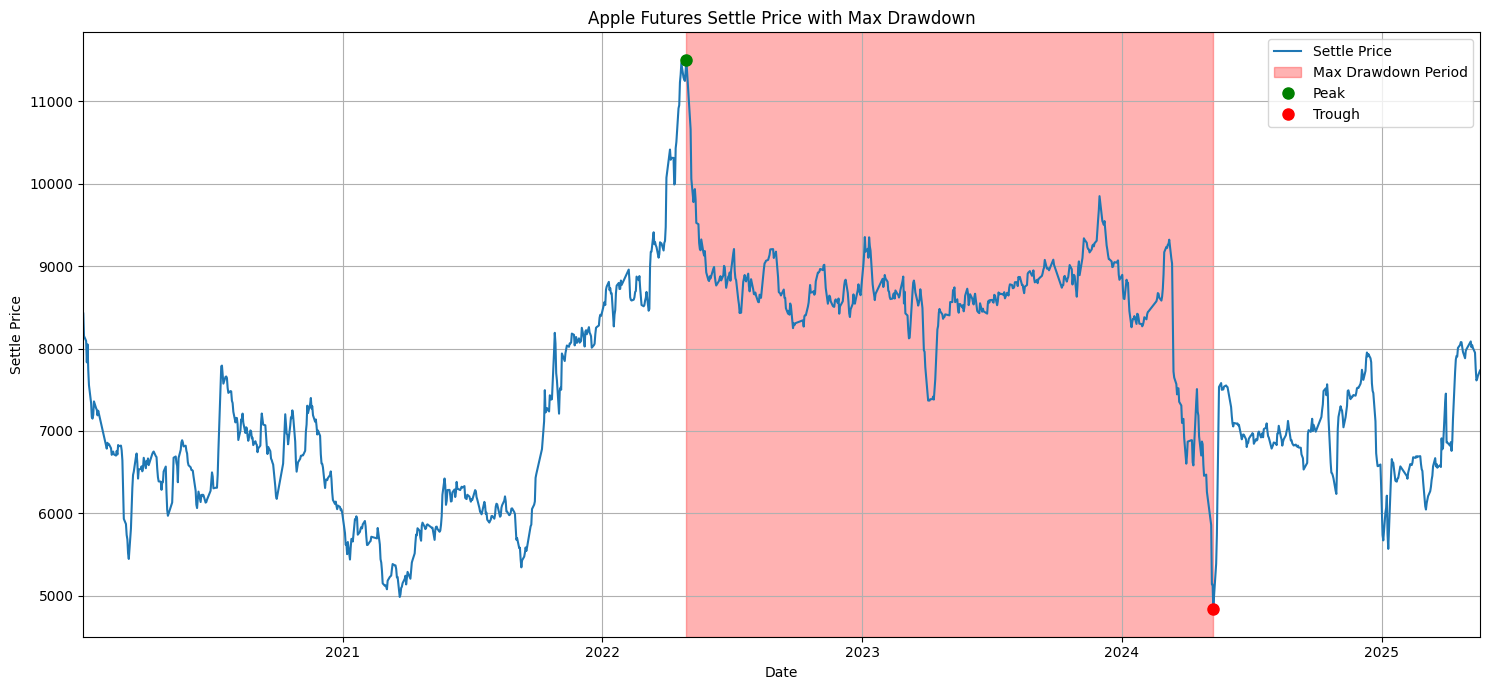

In [24]:
def calculate_max_drawdown(series):

    series = pd.to_numeric(series, errors='coerce').dropna()

    if series.empty:
        return 0.0, None, None, None

    cum_max = series.expanding(min_periods=1).max()

    drawdown = (series / cum_max) - 1

    max_drawdown_value = drawdown.min()

    end_date_index = drawdown.idxmin()
    peak_date_index = cum_max.loc[:end_date_index].idxmax()

    peak_date = peak_date_index
    end_date = end_date_index

    peak_value = series.loc[peak_date_index]
    if isinstance(peak_value, pd.Series):
        peak_value = peak_value.iloc[0]

    return max_drawdown_value, peak_date, end_date, peak_value

apple_settle_series = apple_continuous_final.set_index('Date')['Settle']

md_price, peak_date_price, end_date_price, peak_value_price = calculate_max_drawdown(apple_settle_series)
print(f"\nMax Drawdown (Settle Price): {md_price:.2%}")
print(f"Peak Value (Settle Price): {peak_value_price:.2f} on {peak_date_price.strftime('%Y-%m-%d')}")
print(f"Trough (Settle Price): {apple_settle_series.loc[end_date_price]:.2f} on {end_date_price.strftime('%Y-%m-%d')}")

plt.figure(figsize=(15, 7))
plt.plot(apple_continuous_final['Date'], apple_continuous_final['Settle'], label='Settle Price')

plt.axvspan(peak_date_price, end_date_price, color='red', alpha=0.3, label='Max Drawdown Period')

plt.plot(peak_date_price, peak_value_price, 'go', markersize=8, label='Peak')
plt.plot(end_date_price, apple_settle_series.loc[end_date_price], 'ro', markersize=8, label='Trough')

plt.title('Apple Futures Settle Price with Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Settle Price')
plt.legend()
plt.grid(True)
plt.margins(x=0)
plt.tight_layout()
plt.show()

#### Calculating the VaR and CVaR for apple fruit prices returns

The calculated Var and CVaRs show considerable daily risk, but nothing extremely volatile.

With 95% confidence, the daily VaR is around 3% and with 99% is around 5%.

In [25]:
from scipy.stats import norm

confidence_levels = [0.05, 0.01]

print("\n--- Daily Value at Risk (VaR) and Conditional VaR (CVaR) for Apple Futures ---")

for alpha in confidence_levels:
    print(f"\nConfidence Level: {(1 - alpha):.2%}")

    # 1. Historical VaR

    historical_var = -logr.quantile(alpha)
    print(f"  Historical Daily VaR: {historical_var:.4f} ({historical_var:.2%})")

    # 2. Parametric VaR (Gaussian)

    mu = logr.mean()
    sigma = logr.std(ddof=1) # Use sample standard deviation

    parametric_var = -norm.ppf(alpha, mu, sigma)
    print(f"  Parametric (Gaussian) Daily VaR: {parametric_var:.4f} ({parametric_var:.2%})")

    # 3. Conditional VaR (CVaR) / Expected Shortfall (ES)

    historical_cvar = -logr[logr < -historical_var].mean()
    if pd.isna(historical_cvar):
        historical_cvar = 'N/A (No observations below VaR)'
    print(f"  Historical Daily CVaR: {historical_cvar}")

    parametric_cvar = -(mu - sigma * norm.pdf(norm.ppf(alpha)) / alpha)
    print(f"  Parametric (Gaussian) Daily CVaR: {parametric_cvar:.4f} ({parametric_cvar:.2%})")


--- Daily Value at Risk (VaR) and Conditional VaR (CVaR) for Apple Futures ---

Confidence Level: 95.00%
  Historical Daily VaR: 0.0295 (2.95%)
  Parametric (Gaussian) Daily VaR: 0.0318 (3.18%)
  Historical Daily CVaR: 0.04595951490410529
  Parametric (Gaussian) Daily CVaR: 0.0399 (3.99%)

Confidence Level: 99.00%
  Historical Daily VaR: 0.0560 (5.60%)
  Parametric (Gaussian) Daily VaR: 0.0450 (4.50%)
  Historical Daily CVaR: 0.07721658616857721
  Parametric (Gaussian) Daily CVaR: 0.0515 (5.15%)


## Exchange Rate Hedge

In [26]:
tbill_3month_yield = yf.download('^IRX', start='2020-01-01', end='2025-12-31')
# Select the specific 'Close' column from the MultiIndex and rename the resulting Series
tbill_3month_yield = tbill_3month_yield[('Close', '^IRX')].rename('3M T-Bill Yield')
tbill_3month_yield = tbill_3month_yield.to_frame()

[*********************100%***********************]  1 of 1 completed


In [28]:
from pathlib import Path

def get_china_interest_rate_path():
    # 1. Try Google Colab path first
    colab_path = Path('/content/drive/MyDrive/MeusLogs/taxa de juros china.txt')
    if colab_path.exists():
        return str(colab_path)
    
    # 2. Try local PC path
    YOUR_LOCAL_PC_BASE_PATH = 'G:/Meu Drive/MeusLogs'
    if YOUR_LOCAL_PC_BASE_PATH:
        pc_path = Path(YOUR_LOCAL_PC_BASE_PATH) / 'taxa de juros china.txt'
        if pc_path.exists():
            return str(pc_path)
    
    # 3. Try current working directory
    cwd_path = Path.cwd() / 'taxa de juros china.txt'
    if cwd_path.exists():
        return str(cwd_path)
    
    raise FileNotFoundError(f"Could not find 'taxa de juros china.txt' in any expected location")

# datasource China Interest rate: https://www.tradingview.com/symbols/ECONOMICS-CNINTR/reports-history/
file_path = get_china_interest_rate_path()
print(f'Reading China interest rate from: {file_path}')

china_interest_rate = pd.read_csv(file_path, sep = '|')
china_interest_rate.columns = [['Date','C1', 'Interest Rate', 'C3', 'C4' ]]
china_interest_rate = china_interest_rate.drop(columns = ['C1', 'C3', 'C4'])
china_interest_rate = china_interest_rate.set_index('Date')

china_interest_rate.index = china_interest_rate.index.str[0]
china_interest_rate.index = pd.to_datetime(china_interest_rate.index.str.strip())
china_interest_filled = china_interest_rate.reindex(index = tbill_3month_yield.index, method='ffill')


tbill_3month_yield['3M T-Bill Yield'] = tbill_3month_yield['3M T-Bill Yield'] / 100

china_interest_filled.columns = china_interest_filled.columns.get_level_values(0)
china_interest_filled['Interest Rate'] = china_interest_filled['Interest Rate'].str.replace('%', '', regex=False)
china_interest_filled['Interest Rate'] = pd.to_numeric(china_interest_filled['Interest Rate']) / 100

df_yuan_dollar_adjusted.columns = df_yuan_dollar_adjusted.columns.get_level_values(0)
df_yuan_dollar_adjusted['Returns_CNY'] = np.log(df_yuan_dollar_adjusted['Close'] / df_yuan_dollar_adjusted['Close'].shift(1))
df_yuan_dollar_adjusted = df_yuan_dollar_adjusted.dropna()


Reading China interest rate from: G:\Meu Drive\MeusLogs\taxa de juros china.txt


C:\Users\victo\AppData\Local\Temp\ipykernel_23768\1101061885.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  china_interest_rate = china_interest_rate.drop(columns = ['C1', 'C3', 'C4'])


In [29]:
# Helper function to get backup path
def get_backup_path():
    # 1. Try Google Colab path first
    colab_path = Path('/content/drive/MyDrive/MeusLogs/apple_dfs_backup.csv')
    if colab_path.parent.exists():
        return str(colab_path)
    
    # 2. Try local PC path
    YOUR_LOCAL_PC_BASE_PATH = 'G:/Meu Drive/MeusLogs'
    if YOUR_LOCAL_PC_BASE_PATH:
        pc_path = Path(YOUR_LOCAL_PC_BASE_PATH) / 'apple_dfs_backup.csv'
        pc_path.parent.mkdir(parents=True, exist_ok=True)
        return str(pc_path)
    
    raise FileNotFoundError("Could not determine backup path")

output_path = get_backup_path()
apple_dfs.to_csv(output_path, index=False)
print(f'apple_dfs saved to {output_path}')


apple_dfs saved to G:\Meu Drive\MeusLogs\apple_dfs_backup.csv


In [30]:
'''
df_hedge = df_yuan_dollar_adjusted.join(tbill_3month_yield['3M T-Bill Yield'], how='inner')
df_hedge = df_hedge.join(china_interest_filled['Interest Rate'], how='inner')

df_hedge = df_hedge[['Returns_CNY', '3M T-Bill Yield', 'Interest Rate']]
df_hedge = df_hedge.dropna()

print(df_hedge.head())
'''

"\ndf_hedge = df_yuan_dollar_adjusted.join(tbill_3month_yield['3M T-Bill Yield'], how='inner')\ndf_hedge = df_hedge.join(china_interest_filled['Interest Rate'], how='inner')\n\ndf_hedge = df_hedge[['Returns_CNY', '3M T-Bill Yield', 'Interest Rate']]\ndf_hedge = df_hedge.dropna()\n\nprint(df_hedge.head())\n"

In [31]:
apple_continuous_final['LogReturns_USD'] = np.log(apple_continuous_final['Price_USD'] / apple_continuous_final['Price_USD'].shift(1))
apple_continuous_final = apple_continuous_final.dropna()

In [32]:
df_hedge_Apple_USD = df_yuan_dollar_adjusted.join(apple_continuous_final['LogReturns_USD'], how='inner')

In [33]:
model_apple_usd = smf.ols('LogReturns_USD ~ Returns_CNY', data=df_hedge_Apple_USD)
results_hedge_apple_usd = model_apple_usd.fit()

###### Approximately 4% of the returns on apple futures are explained by the exchange rate variation between the yuan and the dollar.

In [34]:
print(results_hedge_apple_usd.summary())

                            OLS Regression Results                            
Dep. Variable:         LogReturns_USD   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     53.94
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           3.64e-13
Time:                        22:35:51   Log-Likelihood:                 3284.5
No. Observations:                1299   AIC:                            -6565.
Df Residuals:                    1297   BIC:                            -6555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.303e-05      0.001     -0.118      

Hedge Ratio: -1.1066
----------------------------------------
Variance Without Hedge : 0.000388
Variance with Hedge : 0.000373
Total risk reduction      : 3.99%
----------------------------------------


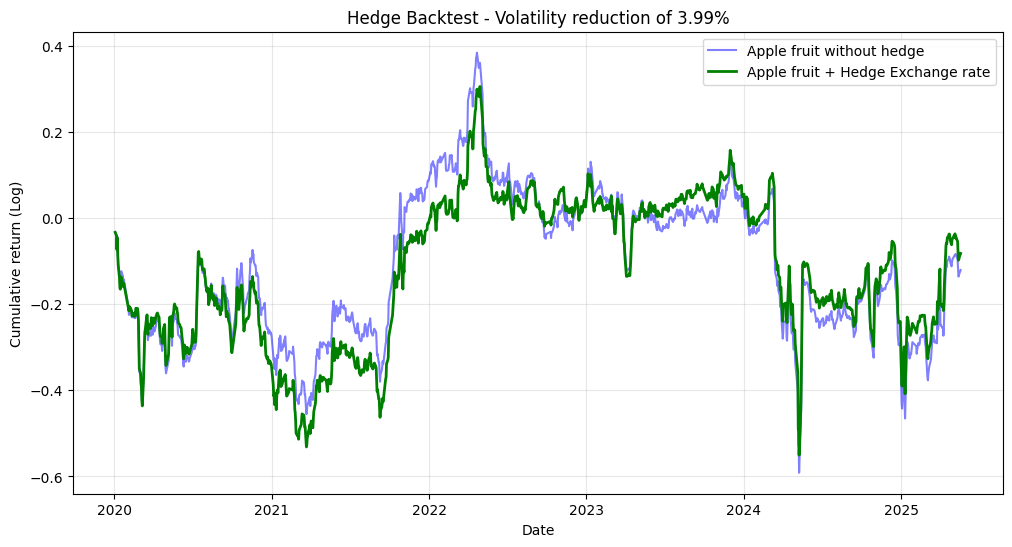

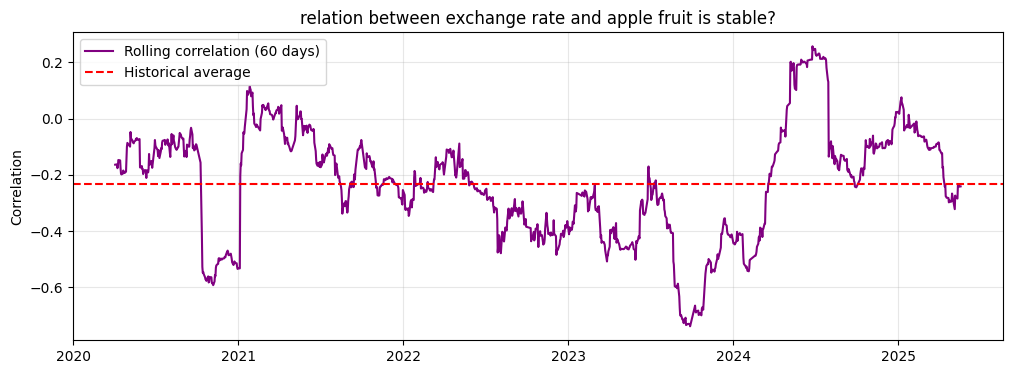

In [35]:
# Hedge ratio

hedge_ratio = results_hedge_apple_usd.params['Returns_CNY']
print(f"Hedge Ratio: {hedge_ratio:.4f}")

# Backtest
# Portfolio Return = Asset Return - (Hedge_Ratio * Hedge_return)

df_hedge_Apple_USD['Hedged_Returns'] = df_hedge_Apple_USD['LogReturns_USD'] - (hedge_ratio * df_hedge_Apple_USD['Returns_CNY'])

# Variance reduction
var_without_hedge = df_hedge_Apple_USD['LogReturns_USD'].var()
var_with_hedge = df_hedge_Apple_USD['Hedged_Returns'].var()

risk_reduction = 1 - (var_with_hedge / var_without_hedge)

print("-" * 40)
print(f"Variance Without Hedge : {var_without_hedge:.6f}")
print(f"Variance with Hedge : {var_with_hedge:.6f}")
print(f"Total risk reduction      : {risk_reduction:.2%}")
print("-" * 40)

# Cumulative result
df_hedge_Apple_USD['Cum_Ret_NoHedge'] = df_hedge_Apple_USD['LogReturns_USD'].cumsum()
df_hedge_Apple_USD['Cum_Ret_Hedged'] = df_hedge_Apple_USD['Hedged_Returns'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_hedge_Apple_USD.index, df_hedge_Apple_USD['Cum_Ret_NoHedge'], label='Apple fruit without hedge', color='blue', alpha=0.5)
plt.plot(df_hedge_Apple_USD.index, df_hedge_Apple_USD['Cum_Ret_Hedged'], label='Apple fruit + Hedge Exchange rate', color='green', linewidth=2)

plt.title(f'Hedge Backtest - Volatility reduction of {risk_reduction:.2%}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Cumulative return (Log)')
plt.xlabel('Date')
plt.show()

# Stability check
rolling_corr = df_hedge_Apple_USD['LogReturns_USD'].rolling(window=60).corr(df_hedge_Apple_USD['Returns_CNY'])

plt.figure(figsize=(12, 4))
plt.plot(rolling_corr.index, rolling_corr, color='purple', label='Rolling correlation (60 days)')
plt.axhline(y=rolling_corr.mean(), color='r', linestyle='--', label='Historical average')
plt.title('relation between exchange rate and apple fruit is stable?')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

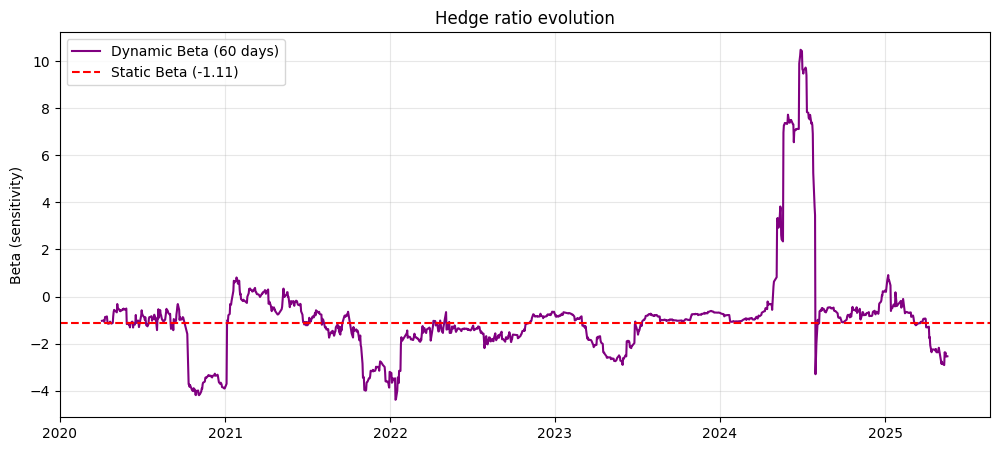

Variance without hedge:        0.000388
Variance static hedge   0.000373
Variance dynamic hedge:   0.000373
Improvement static: 3.99%
Improvement Dynamic: 3.88%


In [36]:
import matplotlib.pyplot as plt


window = 60  # Using last 60 days to calibrate the hedge

# 1
rolling_var = df_hedge_Apple_USD['Returns_CNY'].rolling(window=window).var()

# 2
rolling_cov = df_hedge_Apple_USD['LogReturns_USD'].rolling(window=window).cov(df_hedge_Apple_USD['Returns_CNY'])

# 3. Rolling beta
df_hedge_Apple_USD['Dynamic_Beta'] = rolling_cov / rolling_var

# Avoiding look-ahead bias
df_hedge_Apple_USD['Hedge_Ratio_Dynamic'] = df_hedge_Apple_USD['Dynamic_Beta'].shift(1)

# 4 Dynamic hedging returns
df_hedge_Apple_USD['Dynamic_Hedged_Returns'] = df_hedge_Apple_USD['LogReturns_USD'] - (
    df_hedge_Apple_USD['Hedge_Ratio_Dynamic'] * df_hedge_Apple_USD['Returns_CNY']
)

# ---


plt.figure(figsize=(12, 5))
plt.plot(df_hedge_Apple_USD.index, df_hedge_Apple_USD['Dynamic_Beta'], label='Dynamic Beta (60 days)', color='purple')
plt.axhline(y=hedge_ratio, color='red', linestyle='--', label=f'Static Beta ({hedge_ratio:.2f})')
plt.title('Hedge ratio evolution')
plt.ylabel('Beta (sensitivity)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


var_static_hedge = df_hedge_Apple_USD['Hedged_Returns'].var() # from the other step
var_dynamic_hedge = df_hedge_Apple_USD['Dynamic_Hedged_Returns'].dropna().var()

print(f"Variance without hedge:        {var_without_hedge:.6f}")
print(f"Variance static hedge   {var_static_hedge:.6f}")
print(f"Variance dynamic hedge:   {var_dynamic_hedge:.6f}")

red_static = 1 - (var_static_hedge / var_without_hedge)
red_dynamic = 1 - (var_dynamic_hedge / var_without_hedge)

print(f"Improvement static: {red_static:.2%}")
print(f"Improvement Dynamic: {red_dynamic:.2%}")

Redução de Risco (Estático -1.10):      3.99%
Redução de Risco (Dinâmico Limitado 2): 5.67%


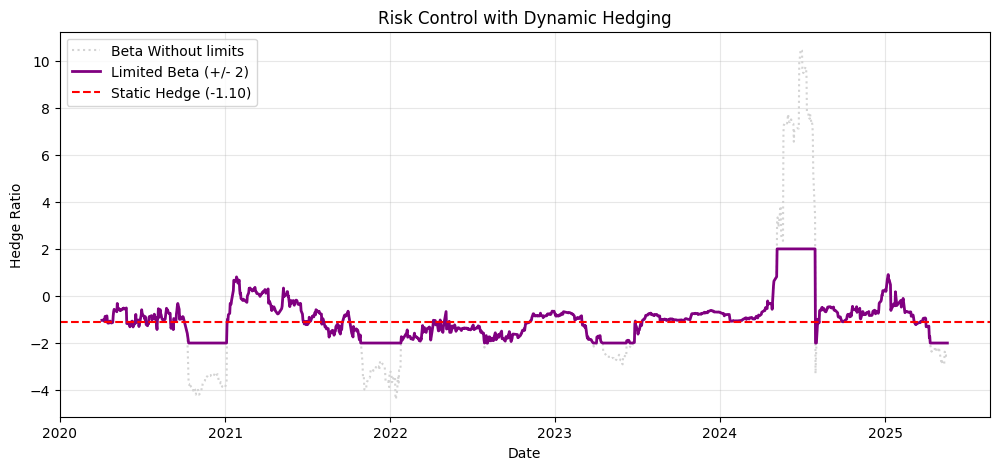

In [37]:
import matplotlib.pyplot as plt

# Dynamic hedge with a limit to avoid over leverage
window = 60
limit = 2.0

# 1
rolling_cov = df_hedge_Apple_USD['LogReturns_USD'].rolling(window=window).cov(df_hedge_Apple_USD['Returns_CNY'])
rolling_var = df_hedge_Apple_USD['Returns_CNY'].rolling(window=window).var()

df_hedge_Apple_USD['Dynamic_Beta'] = rolling_cov / rolling_var

# Applying limit
df_hedge_Apple_USD['Dynamic_Beta_Capped'] = df_hedge_Apple_USD['Dynamic_Beta'].clip(lower=-limit, upper=limit)

# Avoiding look ahead bias
df_hedge_Apple_USD['Hedge_Ratio_Capped'] = df_hedge_Apple_USD['Dynamic_Beta_Capped'].shift(1)

# 4
df_hedge_Apple_USD['Capped_Hedged_Returns'] = df_hedge_Apple_USD['LogReturns_USD'] - (
    df_hedge_Apple_USD['Hedge_Ratio_Capped'] * df_hedge_Apple_USD['Returns_CNY']
)

# Risk reduction

var_dynamic_cap = df_hedge_Apple_USD['Capped_Hedged_Returns'].dropna().var()

red_dynamic_cap = 1 - (var_dynamic_cap / var_without_hedge)

print(f"Risk reduction (Static -1.10):      {red_static:.2%}")
print(f"Risk reduction (dynamic Limited +-2): {red_dynamic_cap:.2%}")


plt.figure(figsize=(12, 5))
plt.plot(df_hedge_Apple_USD.index, df_hedge_Apple_USD['Dynamic_Beta'], label='Beta Without limits', color='lightgray', linestyle=':')
# Limited Beta
plt.plot(df_hedge_Apple_USD.index, df_hedge_Apple_USD['Dynamic_Beta_Capped'], label='Limited Beta (+/- 2)', color='purple', linewidth=2)
plt.axhline(y=-1.10, color='red', linestyle='--', label='Static Hedge (-1.10)')

plt.title('Risk Control with Dynamic Hedging')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Climate Datasets

Climatic data was sourced via the NASA POWER API, covering major apple-producing regions globally. The dataset includes daily observations for:

Average, Maximum, and Minimum Temperatures (°C);

Precipitation levels (mm).

In [ ]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_nasa_weather(lat, lon, start_date="20200101", end_date="20251231"):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOTCORR",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        properties = data['properties']['parameter']
        df = pd.DataFrame(properties)
        df.index = pd.to_datetime(df.index)
        df = df.replace(-999, pd.NA)
        return df
    except Exception as e:
        print(f"Error to download data: {e}")
        return None

def fetch_region_data(nome, coords, start_date, end_date):
    try:
        print(f" -> Downloading {nome}...")
        df = get_nasa_weather(coords['lat'], coords['lon'], start_date, end_date)
        if df is not None:
            df.columns = [f"{nome}_{col}" for col in df.columns]
            return df
    except Exception as e:
        print(f"Error in {nome}: {e}")
        return None

regioes = {
"China_Shaanxi": {"lat": 35.76, "lon": 109.42}, # Yan'an/Luochuan (Heart of the Chinese apple)
"China_Shandong": {"lat": 37.53, "lon": 121.39}, # Yantai (Traditional region)
"Brasil_Vacaria": {"lat": -28.51, "lon": -50.93}, # National reference
"USA_Washington": {"lat": 46.60, "lon": -120.50}, # Yakima Valley (Largest in the USA)
"Polonia_Grojec": {"lat": 51.86, "lon": 20.86}, # Heart of the Mazovia region ("the largest orchard in Europe")
"Italia_Bolzano": {"lat": 46.50, "lon": 11.35}, # Capital of South Tyrol (Südtirol/Alto Adige)
"Franca_Angers": {"lat": 47.47, "lon": -0.56}, # Loire Valley (Pays de la Loire)
"Turquia_Isparta": {"lat": 37.76, "lon": 30.55}, # The province of apples and roses
"Turquia_Karaman": {"lat": 37.18, "lon": 33.21}, # Region with great expansion of orchards
"Turquia_Nigde": {"lat": 37.96, "lon": 34.68}, # Central Anatolia
"India_Srinagar": {"lat": 34.08, "lon": 74.79}, # Jammu and Kashmir (J&K)
"India_Shimla": {"lat": 31.10, "lon": 77.17}, # Himachal Pradesh (Foot of the Himalayas)
"Ira_Urmia": {"lat": 37.55, "lon": 45.07}, # Western Azerbaijan (near Lake Urmia)
"Ira_Damavand": {"lat": 35.70, "lon": 52.05}, # Tehran (Mountainous, productive region)
"Russia_Krasnodar": {"lat": 45.03, "lon": 39.15}, # Southern Russia (Milder climate)
"Russia_Nalchik": {"lat": 43.48, "lon": 43.60}, # Kabardino-Balkaria (North Caucasus)
"Russia_Voronezh": {"lat": 51.67, "lon": 39.18}, # Chernozem Region (Black Earth)
"Russia_Belgorod": {"lat": 50.60, "lon": 36.60}, # Producing border region
}
dfs_clima = []

with ThreadPoolExecutor(max_workers=5) as executor:

    future_to_region = {
        executor.submit(fetch_region_data, nome, coords, "20200101", "20251231"): nome
        for nome, coords in regioes.items()
    }

    for future in as_completed(future_to_region):
        result = future.result()
        if result is not None:
            dfs_clima.append(result)

df_clima_global = pd.concat(dfs_clima, axis=1)
df_clima_global.index.name = 'Date'

 -> A descarregar China_Shaanxi...
 -> A descarregar China_Shandong...
 -> A descarregar Brasil_Vacaria...
 -> A descarregar USA_Washington...
 -> A descarregar Polonia_Grojec...
 -> A descarregar Italia_Bolzano...
 -> A descarregar Italia_Bolzano...
 -> A descarregar Franca_Angers...
 -> A descarregar Turquia_Isparta...
 -> A descarregar Turquia_Karaman...
 -> A descarregar Franca_Angers...
 -> A descarregar Turquia_Isparta...
 -> A descarregar Turquia_Karaman...
 -> A descarregar Turquia_Nigde...
 -> A descarregar Turquia_Nigde...
 -> A descarregar India_Srinagar...
 -> A descarregar India_Srinagar...
 -> A descarregar India_Shimla...
 -> A descarregar India_Shimla...
 -> A descarregar Ira_Urmia...
 -> A descarregar Ira_Damavand...
 -> A descarregar Ira_Urmia...
 -> A descarregar Ira_Damavand...
 -> A descarregar Russia_Krasnodar...
 -> A descarregar Russia_Krasnodar...
 -> A descarregar Russia_Nalchik...
 -> A descarregar Russia_Nalchik...
 -> A descarregar Russia_Voronezh...
 -> A 

In [ ]:
'''
import requests
import time

# Defining regions for analysis
regioes = {
"China_Shaanxi": {"lat": 35.76, "lon": 109.42}, # Yan'an/Luochuan (Heart of the Chinese apple)
"China_Shandong": {"lat": 37.53, "lon": 121.39}, # Yantai (Traditional region)
"Brasil_Vacaria": {"lat": -28.51, "lon": -50.93}, # National reference
"USA_Washington": {"lat": 46.60, "lon": -120.50}, # Yakima Valley (Largest in the USA)
"Polonia_Grojec": {"lat": 51.86, "lon": 20.86}, # Heart of the Mazovia region ("the largest orchard in Europe")
"Italia_Bolzano": {"lat": 46.50, "lon": 11.35}, # Capital of South Tyrol (Südtirol/Alto Adige)
"Franca_Angers": {"lat": 47.47, "lon": -0.56}, # Loire Valley (Pays de la Loire)
"Turquia_Isparta": {"lat": 37.76, "lon": 30.55}, # The province of apples and roses
"Turquia_Karaman": {"lat": 37.18, "lon": 33.21}, # Region with great expansion of orchards
"Turquia_Nigde": {"lat": 37.96, "lon": 34.68}, # Central Anatolia
"India_Srinagar": {"lat": 34.08, "lon": 74.79}, # Jammu and Kashmir (J&K)
"India_Shimla": {"lat": 31.10, "lon": 77.17}, # Himachal Pradesh (Foot of the Himalayas)
"Ira_Urmia": {"lat": 37.55, "lon": 45.07}, # Western Azerbaijan (near Lake Urmia)
"Ira_Damavand": {"lat": 35.70, "lon": 52.05}, # Tehran (Mountainous, productive region)
"Russia_Krasnodar": {"lat": 45.03, "lon": 39.15}, # Southern Russia (Milder climate)
"Russia_Nalchik": {"lat": 43.48, "lon": 43.60}, # Kabardino-Balkaria (North Caucasus)
"Russia_Voronezh": {"lat": 51.67, "lon": 39.18}, # Chernozem Region (Black Earth)
"Russia_Belgorod": {"lat": 50.60, "lon": 36.60}, # Producing border region
}


def get_nasa_weather(lat, lon, start_date="20200101", end_date="20251231"):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOTCORR",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        properties = data['properties']['parameter']
        df = pd.DataFrame(properties)
        df.index = pd.to_datetime(df.index)
        df = df.replace(-999, pd.NA)
        return df
    except Exception as e:
        print(f"Error to download data: {e}")
        return None

dfs_clima = []

print("Downloading climate data...")
for nome, coords in regioes.items():
    print(f" -> {nome}...")
    df_temp = get_nasa_weather(coords['lat'], coords['lon'])

    if df_temp is not None:
        # Rename columns to include the region name (e.g., China_T2M)
        df_temp.columns = [f"{nome}_{col}" for col in df_temp.columns]
        dfs_clima.append(df_temp)

    time.sleep(1) # Pause so the API doesn't get blocked

df_clima_global = pd.concat(dfs_clima, axis=1)
df_clima_global.index.name = 'Date'

df_clima_global.head()
'''

'\nimport requests\nimport time\n\n# Defining regions for analysis\nregioes = {\n"China_Shaanxi": {"lat": 35.76, "lon": 109.42}, # Yan\'an/Luochuan (Heart of the Chinese apple)\n"China_Shandong": {"lat": 37.53, "lon": 121.39}, # Yantai (Traditional region)\n"Brasil_Vacaria": {"lat": -28.51, "lon": -50.93}, # National reference\n"USA_Washington": {"lat": 46.60, "lon": -120.50}, # Yakima Valley (Largest in the USA)\n"Polonia_Grojec": {"lat": 51.86, "lon": 20.86}, # Heart of the Mazovia region ("the largest orchard in Europe")\n"Italia_Bolzano": {"lat": 46.50, "lon": 11.35}, # Capital of South Tyrol (Südtirol/Alto Adige)\n"Franca_Angers": {"lat": 47.47, "lon": -0.56}, # Loire Valley (Pays de la Loire)\n"Turquia_Isparta": {"lat": 37.76, "lon": 30.55}, # The province of apples and roses\n"Turquia_Karaman": {"lat": 37.18, "lon": 33.21}, # Region with great expansion of orchards\n"Turquia_Nigde": {"lat": 37.96, "lon": 34.68}, # Central Anatolia\n"India_Srinagar": {"lat": 34.08, "lon": 74.79},

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_hedge_Apple_USD.index = pd.to_datetime(df_hedge_Apple_USD.index)
df_global_analysis = df_hedge_Apple_USD.join(df_clima_global, how='inner')

for col in df_global_analysis.columns:
    if df_global_analysis[col].dtype == 'object':
        df_global_analysis[col] = pd.to_numeric(df_global_analysis[col], errors='coerce')

df_global_analysis = df_global_analysis.dropna()

features = ['Returns_CNY'] + [c for c in df_global_analysis.columns if 'T2M' in c or 'PRECTOTCORR' in c]
X = df_global_analysis[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values('VIF', ascending=False).head(10))

Y = df_global_analysis['LogReturns_USD']
model_global = sm.OLS(Y,X).fit()

print(model_global.summary())

               Variable         VIF
34  Turquia_Karaman_T2M  764.303720
50     Ira_Damavand_T2M  747.930529
38    Turquia_Nigde_T2M  696.404175
6    China_Shandong_T2M  695.078021
66  Russia_Voronezh_T2M  646.378960
54        Ira_Urmia_T2M  586.172246
70  Russia_Belgorod_T2M  566.493305
30  Turquia_Isparta_T2M  488.755015
42   India_Srinagar_T2M  456.582550
14    China_Shaanxi_T2M  448.287465
                            OLS Regression Results                            
Dep. Variable:         LogReturns_USD   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.636
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000815
Time:                        22:40:51   Log-Likelihood:                 3180.7
No. Observations:                1239   AIC:                            -6213.
Df Residuals:                    1165   BIC:       

In [41]:
# Exchange rate + CHINA (Shandong & Shaanxi) ---

# 1. Selecting variables

features_china = [
    'Returns_CNY',
    'China_Shandong_T2M', 'China_Shandong_PRECTOTCORR',
    'China_Shaanxi_T2M', 'China_Shaanxi_PRECTOTCORR'
]

cols_final = [c for c in features_china if c in df_global_analysis.columns]
X_china = df_global_analysis[cols_final]
X_china = sm.add_constant(X_china)

# 2
print("-" * 40)
print("New VIF (Selected)")
print("-" * 40)

vif_china = pd.DataFrame()
vif_china["variable"] = X_china.columns

vif_china["VIF"] = [variance_inflation_factor(X_china.values.astype(float), i) for i in range(X_china.shape[1])]
print(vif_china)

Y = df_global_analysis['LogReturns_USD']
model_china = sm.OLS(Y, X_china.astype(float)).fit()

print("\n" + "=" * 40)
print("RESULT: Exchange Rate + Chinese climate")
print("=" * 40)
print(model_china.summary())

----------------------------------------
New VIF (Selected)
----------------------------------------
                     variable        VIF
0                       const   3.078879
1                 Returns_CNY   1.002536
2          China_Shandong_T2M  11.049165
3  China_Shandong_PRECTOTCORR   1.040344
4           China_Shaanxi_T2M  10.689121
5   China_Shaanxi_PRECTOTCORR   1.102303

RESULT: Exchange Rate + Chinese climate
                            OLS Regression Results                            
Dep. Variable:         LogReturns_USD   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.86
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           3.18e-11
Time:                        22:40:51   Log-Likelihood:                 3149.3
No. Observations:                1239   AIC:                            -6287.
Df Residuals:     

In [ ]:
# Model with China, USA and Italy

target_regions = [
    'China_Shandong',
    'China_Shaanxi',
    'USA_Washington',
    'Italia_Bolzano'
]

features_world = ['Returns_CNY'] #

for region in target_regions:

    features_world.extend([
        f'{region}_T2M',       # Average
        f'{region}_T2M_MAX',   # Max
        f'{region}_T2M_MIN',   # Min
        f'{region}_PRECTOTCORR' # Rain
    ])


cols_world = [c for c in features_world if c in df_global_analysis.columns]
X_world = df_global_analysis[cols_world]
X_world = sm.add_constant(X_world)


print("-" * 40)
print("VIF: China, USA and Italy")
print("-" * 40)
vif_world = pd.DataFrame()
vif_world["Variable"] = X_world.columns
vif_world["VIF"] = [variance_inflation_factor(X_world.values.astype(float), i) for i in range(X_world.shape[1])]
print(vif_world.sort_values('VIF', ascending=False))

# 4. Regressão
Y = df_global_analysis['LogReturns_USD']
model_world = sm.OLS(Y, X_world.astype(float)).fit()

print("\n" + "=" * 50)
print("Result: China, USA and Italy")
print("=" * 50)
print(model_world.summary())

----------------------------------------
VIF: China, USA and Italy
----------------------------------------
                      Variavel         VIF
2           China_Shandong_T2M  613.149212
6            China_Shaanxi_T2M  353.575785
10          USA_Washington_T2M  311.499327
14          Italia_Bolzano_T2M  226.810965
4       China_Shandong_T2M_MIN  176.317252
3       China_Shandong_T2M_MAX  148.163158
11      USA_Washington_T2M_MAX  133.473018
7        China_Shaanxi_T2M_MAX  108.644035
8        China_Shaanxi_T2M_MIN   84.018156
15      Italia_Bolzano_T2M_MAX   76.800242
16      Italia_Bolzano_T2M_MIN   57.484503
12      USA_Washington_T2M_MIN   55.024181
0                        const   54.026448
13  USA_Washington_PRECTOTCORR    1.403929
17  Italia_Bolzano_PRECTOTCORR    1.312059
9    China_Shaanxi_PRECTOTCORR    1.308908
5   China_Shandong_PRECTOTCORR    1.147403
1                  Returns_CNY    1.013957

Result: China, USA and Italy
                            OLS Regression Re